In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = Path('./data/')

In [3]:
list(path.iterdir())

[PosixPath('data/session_df.csv'),
 PosixPath('data/data-science-bowl-2019.zip'),
 PosixPath('data/specs.csv'),
 PosixPath('data/train_labels.csv'),
 PosixPath('data/train.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/test.csv')]

## Read in data

In [4]:
session_df = pd.read_csv(path/'session_df.csv',index_col=0)
train_labels = pd.read_csv(path/'train_labels.csv')
test_data = pd.read_csv(path/'test.csv')
specs = pd.read_csv(path/'specs.csv')

/data/kgloftis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/data/kgloftis/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Reduce the size of the data frames

In [7]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
# train_data = reduce_mem_usage(train_data)
train_labels = reduce_mem_usage(train_labels)
test_data = reduce_mem_usage(test_data)
specs = reduce_mem_usage(specs)
session_df = reduce_mem_usage(session_df)

Mem. usage decreased to  0.49 Mb (0.0% reduction)
Mem. usage decreased to 79.40 Mb (0.0% reduction)
Mem. usage decreased to  0.01 Mb (0.0% reduction)
Mem. usage decreased to 3994.70 Mb (0.0% reduction)


In [9]:
# helper function to decompose dates into more relevant parts
def explode_date(col):
    dayofyear = col.dt.dayofyear
    weekofyear = col.dt.weekofyear
    weekday = col.dt.weekday
    month = col.dt.month
    year = col.dt.year
    hour = col.dt.hour
    quarter = col.dt.quarter
    return pd.DataFrame({'dayofyear':dayofyear,
                         'weekofyear':weekofyear,
                         'weekday':weekday,
                         'quarter':quarter,
                         'month':month,
                         'year':year,
                         'hour':hour})

Main funtion that aggregates the sequence data

In [110]:
def aggregate(df,group_by_col):
    
    first_col = df.groupby(group_by_col,as_index=False)\
                  .count()\
                  .loc[:,group_by_col]
    
    # Number of events
    event_counts = df.groupby(group_by_col)\
                             .agg({'game_session':'count'})\
                             .rename(columns={'game_session':'num_events'})\
                             .reset_index()
    # flag to last event
    last_event = df.groupby(group_by_col,as_index=False)\
                            .agg({'timestamp':'max'})
    last_event['last_event_flag'] = 1
    session_df_last_event_flagged = df.merge(last_event,on=[group_by_col,'timestamp'],how='left')
    # get information about the assessment being predicted (title and world)
    assessment_title = session_df_last_event_flagged\
                          .loc[session_df_last_event_flagged.last_event_flag == 1,'title']
    assessment_world = session_df_last_event_flagged\
                          .loc[session_df_last_event_flagged.last_event_flag==1,'world']
    # get number of types of events (ie clips, activities,...)
    type_count = df.groupby([group_by_col,'type'],as_index=False)\
                           .agg({'timestamp':'count'})\
                           .rename(columns={'timestamp':'num'})\
                           .pivot(index=group_by_col,columns='type', values='num',)\
                           .fillna(0)\
                           .reset_index()
    # Counts number of sessions associated with each type
    type_session_count = df.groupby([group_by_col,'type'],as_index=False)\
                                   .agg({'game_session':'nunique'})\
                                   .rename({'game_session':'ct'})\
                                   .pivot(index=group_by_col,columns='type',values='game_session')\
                                   .fillna(0)\
                                   .reset_index()

    # Get time information about when the assessment was started
    assessment_ts = session_df_last_event_flagged\
                          .loc[session_df_last_event_flagged.last_event_flag == 1,'timestamp']
    assessment_ts_explode = explode_date(pd.to_datetime(assessment_ts))



    return pd.DataFrame({'installation_id':first_col.to_numpy(),
                        'event_counts':event_counts.num_events.to_numpy(),
                        'assessment_title':assessment_title.to_numpy(),
                        'assessment_world':assessment_world.to_numpy(),
                        'activity_count_events':type_count['Activity'].to_numpy(),
                        'assessment_count_events':type_count['Assessment'].to_numpy(),
                        'clip_count_events':type_count['Clip'].to_numpy(),
                        'game_count_events':type_count['Game'].to_numpy(),
                        'activity_count_sessions':type_session_count['Activity'].to_numpy(),
                        'assessment_count_sessions':type_session_count['Assessment'].to_numpy(),
                        'clip_count_sessions':type_session_count['Clip'].to_numpy(),
                        'game_count_sessions':type_session_count['Game'].to_numpy(),
                        'dayofyear_assess':assessment_ts_explode.dayofyear.to_numpy(),
                        'weekofyear_assess':assessment_ts_explode.weekofyear.to_numpy(),
                        'weekday_assess':assessment_ts_explode.weekday.to_numpy(),
                        'quarter_assess':assessment_ts_explode.quarter.to_numpy(),
                        'month_assess':assessment_ts_explode.month.to_numpy(),
                        'hour_assess':assessment_ts_explode.hour.to_numpy()})
seq_agg = aggregate(session_df,'session')

In [128]:
train_data_agg = pd.concat([seq_agg,train_labels.accuracy_group],axis=1)

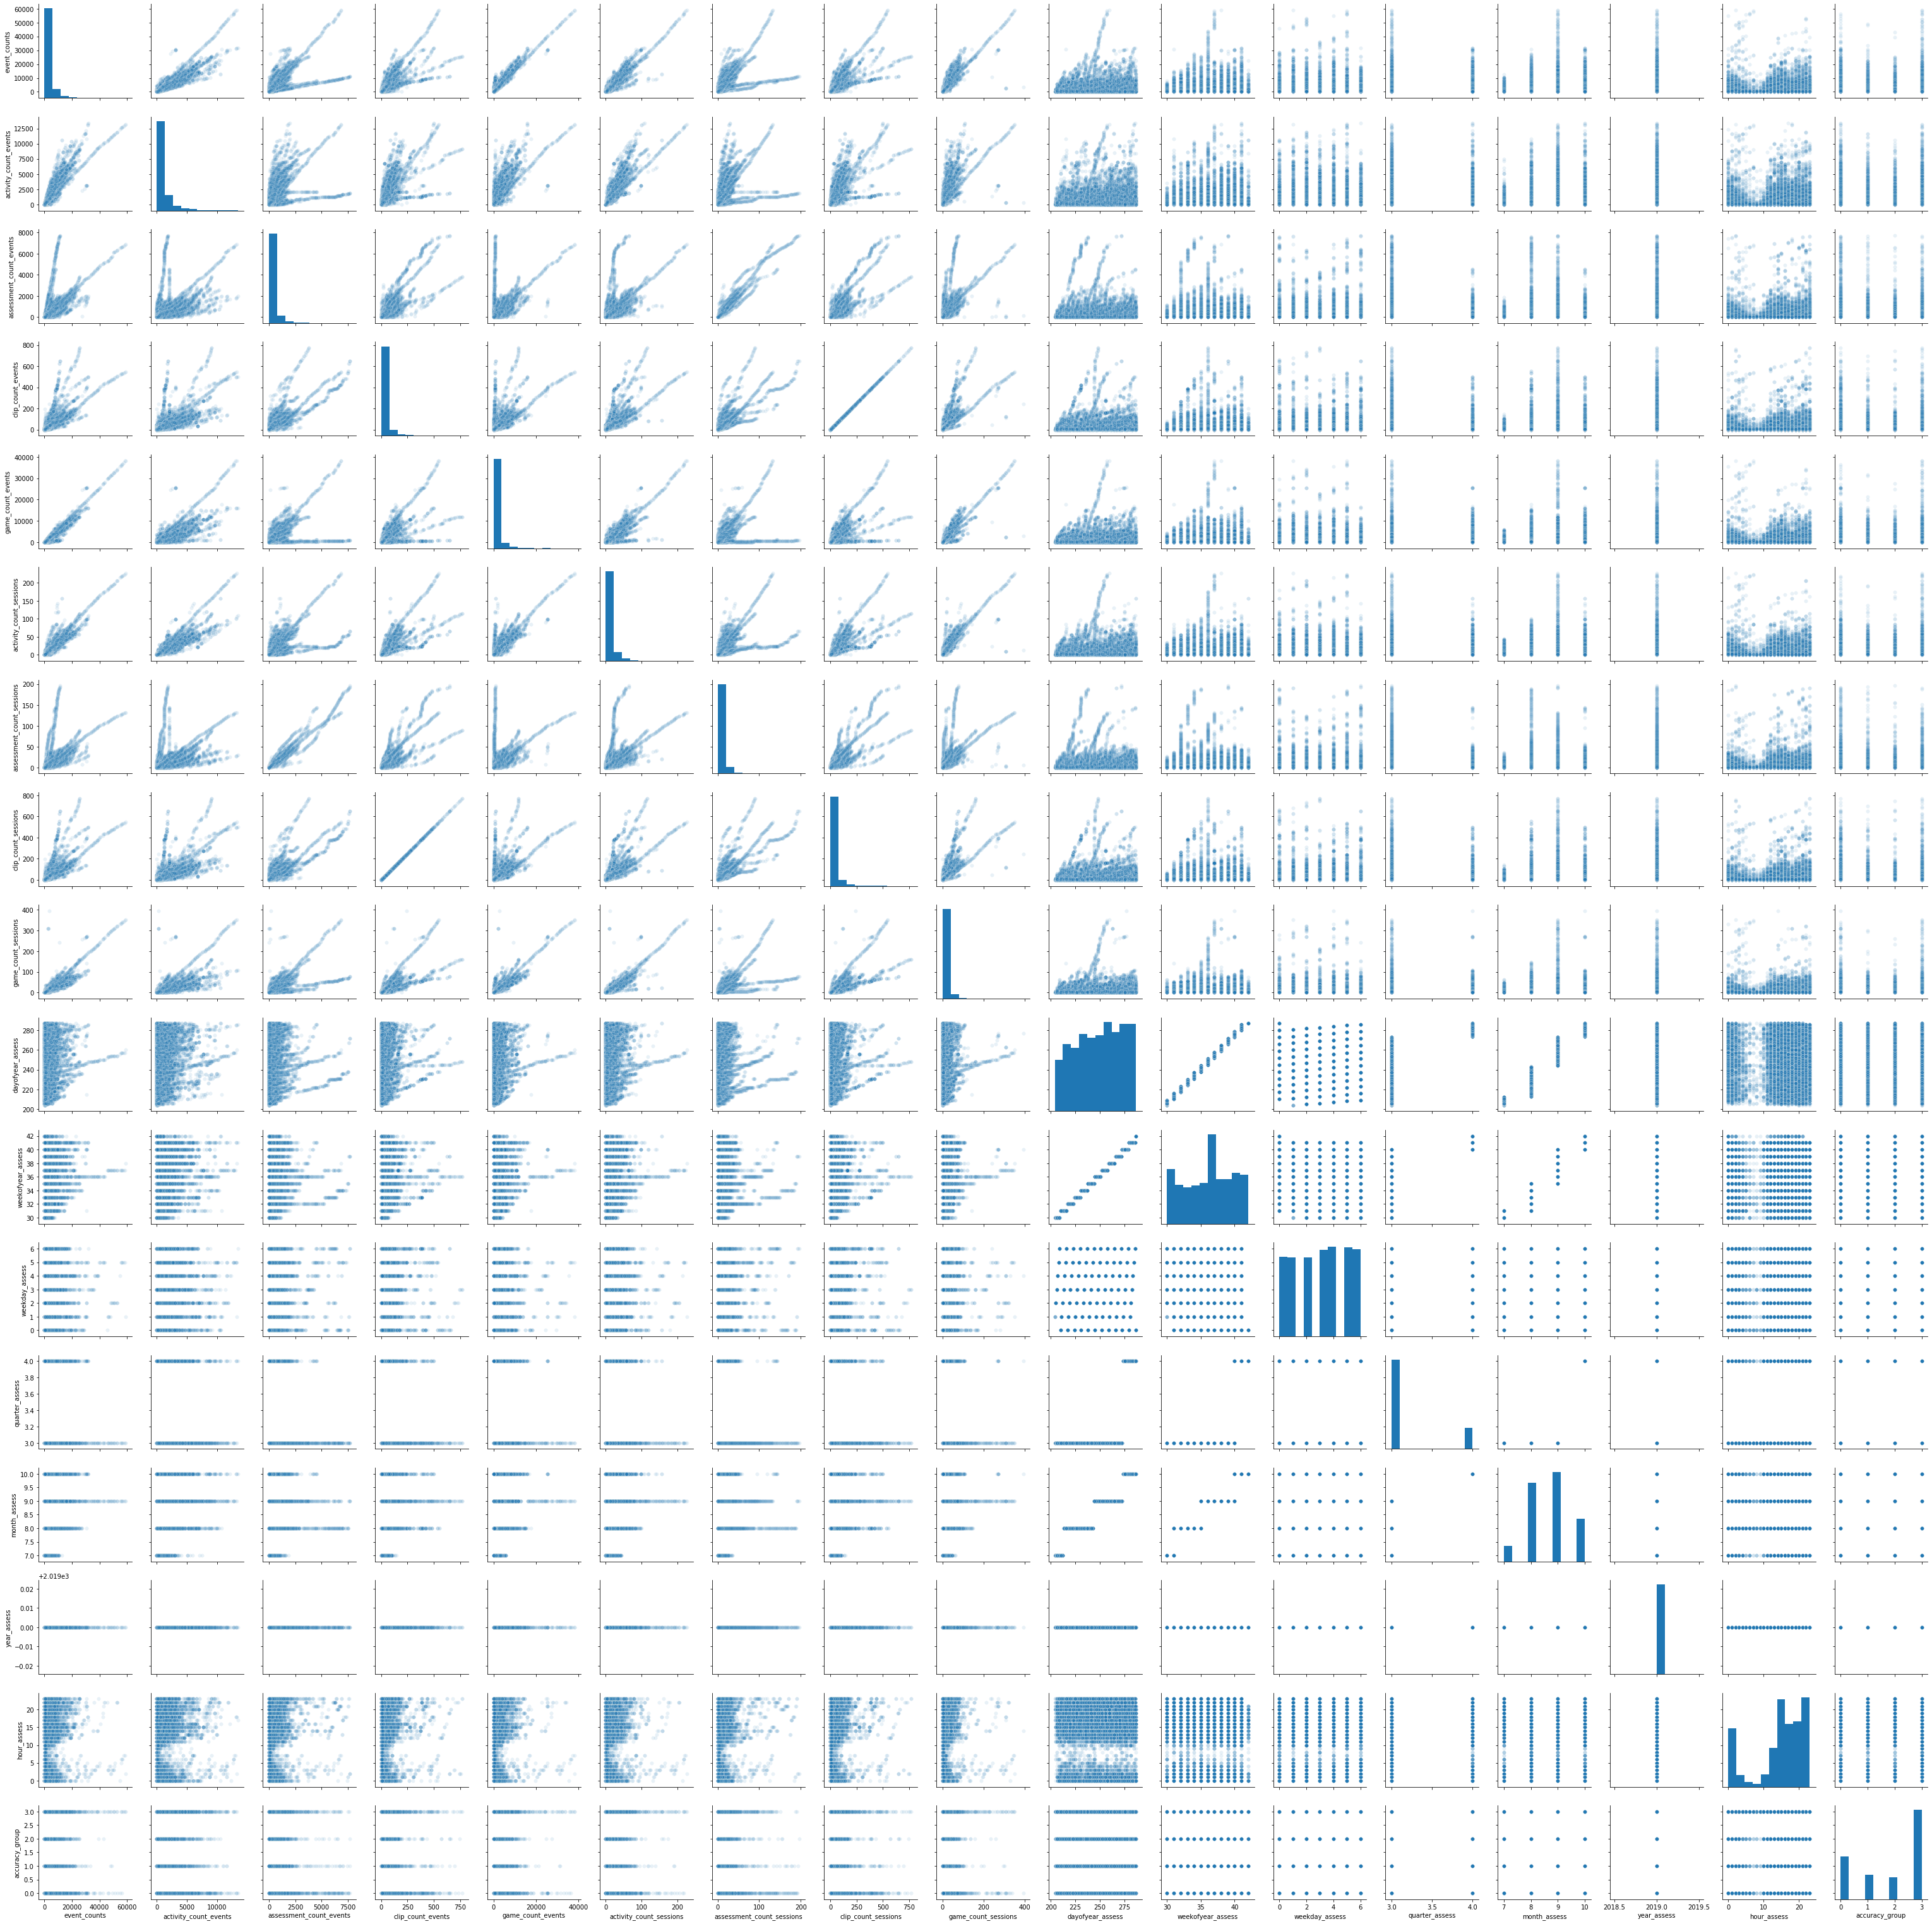

In [16]:
sns.pairplot(train_data_agg,plot_kws={'alpha':0.3})
plt.figure(dpi=150)

# Modeling

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [133]:
def quadratic_kappa(actuals, preds, N=4):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

In [134]:
train,val = train_test_split(train_data_agg,test_size=.2)
all_x = train_data_agg.iloc[:,:-1]
all_y = train_data_agg.iloc[:,-1]
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
val_x = val.iloc[:,:-1]
val_y = val.iloc[:,-1]

In [147]:
preprocessor = ColumnTransformer([('drop','drop',[0]),
                                  ('onehot',OneHotEncoder(),['assessment_title','assessment_world'])],remainder='passthrough')

In [148]:
pipe = Pipeline([('col_transform',preprocessor),
                 ('cls',RandomForestClassifier())])

In [149]:
pipe_fit = pipe.fit(train_x,train_y)

/data/kgloftis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [150]:
params = {'cls__n_estimators':range(1,300,10),
          'cls__max_depth':range(1,15,2),
          'cls__min_samples_leaf':range(10,50,2)}

In [151]:
cv = RandomizedSearchCV(pipe,params,n_jobs=10,n_iter=10)
cv.fit(all_x,all_y)

/data/kgloftis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('col_transform',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('drop',
                                                                               'drop',
                                                                               [0]),
                                                                              ('onehot',
                                                                               OneHotEncoder(categorical_features=None,
             

In [152]:
preds = cv.predict(val_x)
quadratic_kappa(val_y,preds)

0.12674939316985645

In [153]:
test_agg = aggregate(test_data,'installation_id')
test_agg.head()

,installation_id,event_counts,assessment_title,assessment_world,activity_count_events,assessment_count_events,clip_count_events,game_count_events,activity_count_sessions,assessment_count_sessions,clip_count_sessions,game_count_sessions,dayofyear_assess,weekofyear_assess,weekday_assess,quarter_assess,month_assess,hour_assess
0,00abaee7,868,Cauldron Filler (Assessment),MAGMAPEAK,454.0,27.0,14.0,373.0,7.0,2.0,14.0,3.0,255,37,3,3,9,13
1,01242218,2719,Cart Balancer (Assessment),CRYSTALCAVES,1356.0,245.0,29.0,1089.0,11.0,6.0,29.0,12.0,282,41,2,4,10,20
2,017c5718,150,Mushroom Sorter (Assessment),TREETOPCITY,143.0,1.0,6.0,0.0,2.0,1.0,6.0,0.0,264,38,5,3,9,11
3,01a44906,234,Mushroom Sorter (Assessment),TREETOPCITY,145.0,1.0,10.0,78.0,2.0,1.0,10.0,1.0,208,30,5,3,7,16
4,01bc6cb6,952,Cart Balancer (Assessment),CRYSTALCAVES,226.0,1.0,17.0,708.0,1.0,1.0,17.0,6.0,249,36,4,3,9,18


In [156]:
def prepare_submission():
    test_agg = aggregate(test_data,'installation_id')
    test_predictions = cv.predict(test_agg)
    submission_df = pd.DataFrame({'installation_id':test_agg.installation_id.to_numpy(),
                                  'accuracy_group':test_predictions})
    return submission_df
test = prepare_submission()

In [157]:
test.to_csv('submission.csv',index=False)

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
...,...,...
995,fee254cf,3
996,ff57e602,3
997,ffc73fb2,3
998,ffe00ca8,3


In [161]:
test.to_csv('submission/submission.csv',index=False)